In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import shutil
import random
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

Using TensorFlow backend.


In [112]:
# useful functions

def plot_cm(true,pred):
    cm=confusion_matrix(true,pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax=sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    ax.set(xlabel='Prediction', ylabel='Class')
    return ax
#plot_cm(test_ds.classes, test_predict_classes)

# plot train/val accuracy
def plot_accuracy(history):
    ax=plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
#plot_accuracy(history)

# evaluate and plot ROC
def plot_roc(y_true, score, return_pos_rate=False):
    fpr, tpr, threshold=roc_curve(y_true,score)
    roc_auc=auc(fpr, tpr)
    ax=plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="best")
    if return_pos_rate==True:
        return ax, pd.DataFrame({'threshold':threshold, 'True Positive Rate':tpr, 'False Positive Rate':fpr})
    
#q=plot_roc(test_ds.classes, test_predict)

In [2]:
batch_size = 64
img_height = 224
img_width = 224

dataset1_path_train='/storage/Crack_detection/Dataset1_subset_train'
dataset1_path_test='/storage/Crack_detection/Dataset1_subset_test'

train_datagen=ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25)

train_ds=train_datagen.flow_from_directory(
    dataset1_path_train,  
    class_mode='binary',
    subset="training", 
    seed=11, 
    target_size=(img_height, img_width), 
    batch_size=batch_size)

val_datagen=ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25)

val_ds=val_datagen.flow_from_directory(
    dataset1_path_train,  
    class_mode='binary',
    subset="validation", 
    seed=11, 
    target_size=(img_height, img_width), 
    batch_size=batch_size)

test_datagen=ImageDataGenerator(rescale=1./255)

test_ds=test_datagen.flow_from_directory(
    dataset1_path_test, 
    class_mode='binary',
    seed=11, 
    target_size=(img_height, img_width), 
    batch_size=batch_size,
    shuffle=False)

Found 1200 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


## CNN Model

In [48]:
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(5,5), strides=(1,1), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
#model.add(tf.keras.layers.Conv2D(64, kernel_size=(5,5), strides=(1,1), activation='relu'))
#model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.build(input_shape=(img_height, img_width, 3))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 220, 220, 32)      2432      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 387200)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               38720100  
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 38,722,633
Trainable params: 38,722,633
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

history=model.fit(
    train_ds,
    validation_data=val_ds, 
    epochs=15)

Epoch 1/15
19/19 [==============================] - 33s 2s/step - loss: 14.7363 - accuracy: 0.5140 - val_loss: 0.3876 - val_accuracy: 0.8475
Epoch 2/15
19/19 [==============================] - 30s 2s/step - loss: 0.4986 - accuracy: 0.8539 - val_loss: 0.3604 - val_accuracy: 0.9375
Epoch 3/15
19/19 [==============================] - 31s 2s/step - loss: 0.2783 - accuracy: 0.9322 - val_loss: 0.1953 - val_accuracy: 0.9400
Epoch 4/15
19/19 [==============================] - 30s 2s/step - loss: 0.1633 - accuracy: 0.9473 - val_loss: 0.1548 - val_accuracy: 0.9425
Epoch 5/15
19/19 [==============================] - 30s 2s/step - loss: 0.1161 - accuracy: 0.9525 - val_loss: 0.1193 - val_accuracy: 0.9600
Epoch 6/15
19/19 [==============================] - 30s 2s/step - loss: 0.0826 - accuracy: 0.9699 - val_loss: 0.1194 - val_accuracy: 0.9575
Epoch 7/15
19/19 [==============================] - 29s 2s/step - loss: 0.0872 - accuracy: 0.9788 - val_loss: 0.1353 - val_accuracy: 0.9475
Epoch 8/15
19/19 [=

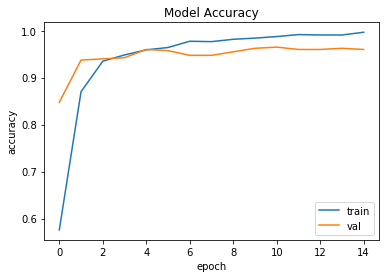

In [50]:
# plot train and val accuracy
plot_accuracy(history)

In [121]:
# prediction and evaluation on test dataset
test_predict=model.predict(test_ds)
test_loss, test_accuracy=model.evaluate(test_ds)
model_accuracy=[np.round(history.history['accuracy'][-1],3), np.round(history.history['val_accuracy'][-1],3), np.round(test_accuracy,3)]    
print(pd.DataFrame({'CNN':model_accuracy}, index=['Train Accuracy', 'Val Accuracy', 'Test Accuracy']))

7/7 [==============================] - 2s 217ms/step - loss: 0.1143 - accuracy: 0.9575
                  CNN
Train Accuracy  0.997
Val Accuracy    0.960
Test Accuracy   0.957


## CNN Model with dropout regularization 

In [57]:
# model with regularization
model_reg=tf.keras.models.Sequential()
model_reg.add(tf.keras.layers.Conv2D(32, kernel_size=(5,5), strides=(1,1), activation='relu', input_shape=(img_height, img_width, 3)))
model_reg.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
#model_reg.add(tf.keras.layers.Conv2D(64, kernel_size=(5,5), strides=(1,1), activation='relu'))
#model_reg.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model_reg.add(tf.keras.layers.Flatten())
model_reg.add(tf.keras.layers.Dropout(0.2))
model_reg.add(tf.keras.layers.Dense(100, activation='relu'))
model_reg.add(tf.keras.layers.Dropout(0.2))
model_reg.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_reg.build(input_shape=(img_height, img_width, 3))
model_reg.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 220, 220, 32)      2432      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 387200)            0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 387200)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               38720100  
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [58]:
model_reg.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

history_reg=model_reg.fit(
    train_ds,
    validation_data=val_ds, 
    epochs=15)

Epoch 1/15
19/19 [==============================] - 35s 2s/step - loss: 18.9526 - accuracy: 0.4861 - val_loss: 0.6569 - val_accuracy: 0.7750
Epoch 2/15
19/19 [==============================] - 33s 2s/step - loss: 0.6751 - accuracy: 0.7221 - val_loss: 0.6820 - val_accuracy: 0.7525
Epoch 3/15
19/19 [==============================] - 32s 2s/step - loss: 0.6745 - accuracy: 0.7777 - val_loss: 0.6402 - val_accuracy: 0.5000
Epoch 4/15
19/19 [==============================] - 32s 2s/step - loss: 0.6680 - accuracy: 0.7865 - val_loss: 0.6618 - val_accuracy: 0.7650
Epoch 5/15
19/19 [==============================] - 33s 2s/step - loss: 0.6417 - accuracy: 0.8415 - val_loss: 0.6020 - val_accuracy: 0.8775
Epoch 6/15
19/19 [==============================] - 33s 2s/step - loss: 0.5285 - accuracy: 0.9136 - val_loss: 0.4507 - val_accuracy: 0.9400
Epoch 7/15
19/19 [==============================] - 33s 2s/step - loss: 0.4084 - accuracy: 0.9278 - val_loss: 0.3669 - val_accuracy: 0.9550
Epoch 8/15
19/19 [=

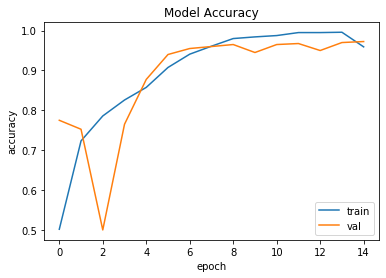

In [59]:
# plot train and val accuracy
plot_accuracy(history_reg)

In [100]:
# prediction and evaluation on test dataset
test_predict_reg=model_reg.predict(test_ds)
test_loss, test_accuracy=model_reg.evaluate(test_ds)
model_reg_accuracy=[np.round(history_reg.history['accuracy'][-1],3), np.round(history_reg.history['val_accuracy'][-1],3), np.round(test_accuracy,3)]    
print(pd.DataFrame({'CNN w/ dropout':model_reg_accuracy}, index=['Train Accuracy', 'Val Accuracy', 'Test Accuracy']))

7/7 [==============================] - 2s 315ms/step - loss: 0.2354 - accuracy: 0.9775
                CNN w/ dropout
Train Accuracy           0.959
Val Accuracy             0.973
Test Accuracy            0.978


## CNN model w/ two convolutional layers and regularization

In [105]:
# model with regularization
model_2conv=tf.keras.models.Sequential()
model_2conv.add(tf.keras.layers.Conv2D(32, kernel_size=(5,5), strides=(1,1), activation='relu', input_shape=(img_height, img_width, 3)))
model_2conv.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model_2conv.add(tf.keras.layers.Conv2D(64, kernel_size=(5,5), strides=(1,1), activation='relu'))
model_2conv.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model_2conv.add(tf.keras.layers.Flatten())
model_2conv.add(tf.keras.layers.Dropout(0.2))
model_2conv.add(tf.keras.layers.Dense(100, activation='relu'))
model_2conv.add(tf.keras.layers.Dropout(0.2))
model_2conv.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_2conv.build(input_shape=(img_height, img_width, 3))
model_2conv.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 220, 220, 32)      2432      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 106, 106, 64)      51264     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 53, 53, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 179776)            0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 179776)            0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)              

In [106]:
model_2conv.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

history_2conv=model_2conv.fit(
    train_ds,
    validation_data=val_ds, 
    epochs=15)

Epoch 1/15
19/19 [==============================] - 44s 2s/step - loss: 2.0057 - accuracy: 0.5555 - val_loss: 0.7686 - val_accuracy: 0.5225
Epoch 2/15
19/19 [==============================] - 43s 2s/step - loss: 0.6886 - accuracy: 0.6794 - val_loss: 0.5128 - val_accuracy: 0.7075
Epoch 3/15
19/19 [==============================] - 43s 2s/step - loss: 0.3611 - accuracy: 0.8671 - val_loss: 0.2201 - val_accuracy: 0.8950
Epoch 4/15
19/19 [==============================] - 43s 2s/step - loss: 0.1462 - accuracy: 0.9479 - val_loss: 0.1832 - val_accuracy: 0.9100
Epoch 5/15
19/19 [==============================] - 43s 2s/step - loss: 0.1239 - accuracy: 0.9611 - val_loss: 0.1058 - val_accuracy: 0.9600
Epoch 6/15
19/19 [==============================] - 43s 2s/step - loss: 0.1042 - accuracy: 0.9662 - val_loss: 0.1918 - val_accuracy: 0.9075
Epoch 7/15
19/19 [==============================] - 43s 2s/step - loss: 0.0851 - accuracy: 0.9678 - val_loss: 0.1740 - val_accuracy: 0.9250
Epoch 8/15
19/19 [==

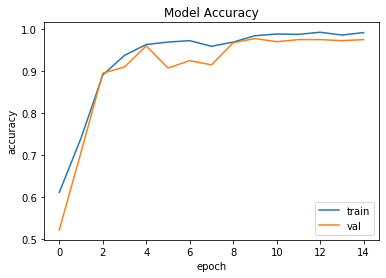

In [113]:
# plot train and val accuracy
plot_accuracy(history_2conv)

In [114]:
# prediction and evaluation on test dataset
test_predict_2conv=model_2conv.predict(test_ds)
test_loss, test_accuracy=model_2conv.evaluate(test_ds)
model_2conv_accuracy=[np.round(history_2conv.history['accuracy'][-1],3), np.round(history_2conv.history['val_accuracy'][-1],3), np.round(test_accuracy,3)]    
print(pd.DataFrame({'CNN 2conv':model_2conv_accuracy}, index=['Train Accuracy', 'Val Accuracy', 'Test Accuracy']))

7/7 [==============================] - 3s 346ms/step - loss: 0.1129 - accuracy: 0.9750
                CNN 2conv
Train Accuracy      0.992
Val Accuracy        0.975
Test Accuracy       0.975


## Models comparison

In [115]:
pd.DataFrame({'CNN':model_accuracy, 'CNN w/ dropout':model_reg_accuracy, 'CNN w/ 2 conv layers':model_2conv_accuracy}, index=['Train Accuracy', 'Val Accuracy', 'Test Accuracy'])

,CNN,CNN w/ dropout,CNN w/ 2 conv layers
Train Accuracy,0.997,0.959,0.992
Val Accuracy,0.960,0.973,0.975
Test Accuracy,0.957,0.978,0.975


Text(0.5, 1.0, 'Val accuracy comparison')

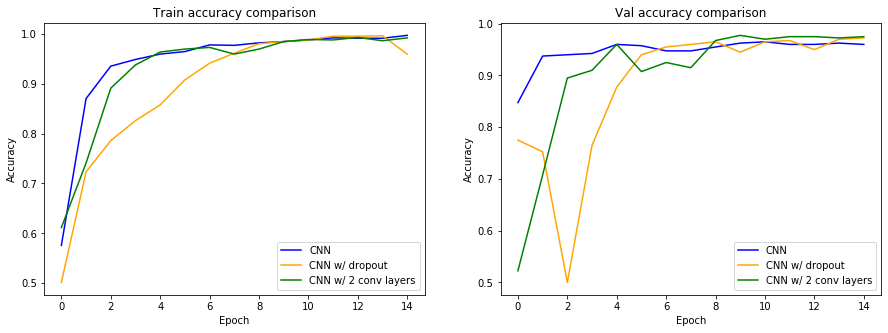

In [119]:
# plot accuracy comparison
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history.history['accuracy'],label='CNN', c='blue')
plt.plot(history_reg.history['accuracy'],label='CNN w/ dropout', c='orange')
plt.plot(history_2conv.history['accuracy'],label='CNN w/ 2 conv layers', c='green')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.title('Train accuracy comparison')
plt.subplot(122)
plt.plot(history.history['val_accuracy'],label='CNN', c='blue')
plt.plot(history_reg.history['val_accuracy'],label='CNN w/ dropout', c='orange')
plt.plot(history_2conv.history['val_accuracy'],label='CNN w/ 2 conv layers', c='green')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.title('Val accuracy comparison')

Text(0.5, 1, 'CNN model w/ 2 conv layers')

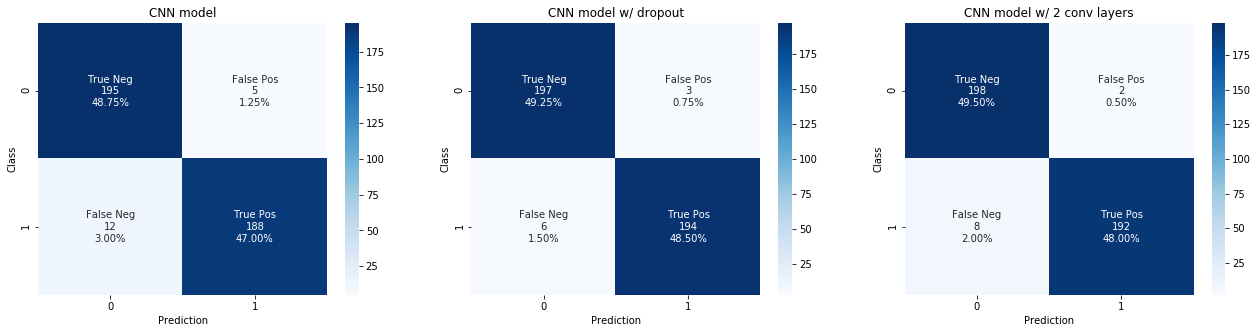

In [125]:
# plot confusion matrix
class_threshold=0.5
test_predict_classes=[1 if i>class_threshold else 0 for i in test_predict]
test_predict_reg_classes=[1 if i>class_threshold else 0 for i in test_predict_reg]
test_predict_2conv_classes=[1 if i>class_threshold else 0 for i in test_predict_2conv]
plt.figure(figsize=(22,5))
plt.subplot(131)
plot_cm(test_ds.classes, test_predict_classes)
plt.title('CNN model')
plt.subplot(132)
plot_cm(test_ds.classes, test_predict_reg_classes)
plt.title('CNN model w/ dropout')
plt.subplot(133)
plot_cm(test_ds.classes, test_predict_2conv_classes)
plt.title('CNN model w/ 2 conv layers')

Text(0.5, 1.0, 'ROC curve for CNN model w/ 2 conv layers')

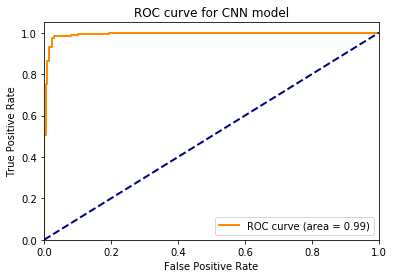

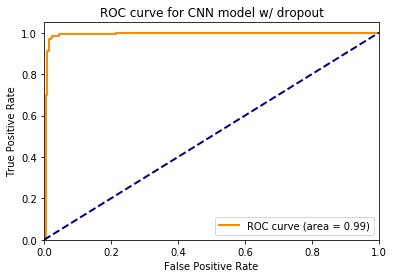

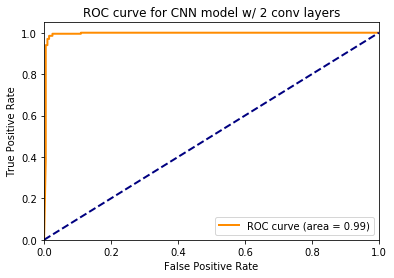

In [120]:
# Plot ROC
ax1=plot_roc(test_ds.classes, test_predict)
plt.title('ROC curve for CNN model')
plot_roc(test_ds.classes, test_predict_reg)
plt.title('ROC curve for CNN model w/ dropout')
plot_roc(test_ds.classes, test_predict_2conv)
plt.title('ROC curve for CNN model w/ 2 conv layers')

## Plot examples of wrong prediction

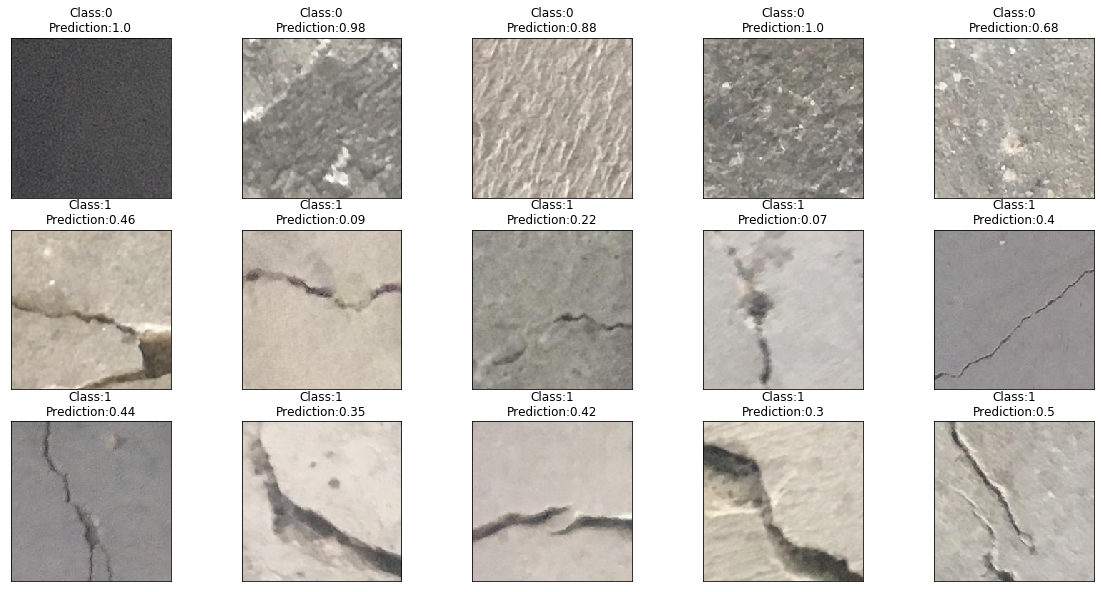

In [32]:
wrong_prediction_index=[]
for position, value in enumerate(test_predict_classes):
    if value != test_ds.classes[position]:
        wrong_prediction_index.append(position)

img_n_rows=len(wrong_prediction_index)//5+1        
image_idx=0
plt.figure(figsize=(20, 10))
for idx in wrong_prediction_index:
    if image_idx<15:
        image=test_ds[int(idx//batch_size)][0][int((idx/batch_size-idx//batch_size)*batch_size)]
        plt.subplot(3, 5, image_idx + 1)
        #plt.subplots(img_n_rows,5, image_idx)
        plt.imshow(image)
        plt.title('Class:' + str(test_ds.classes[idx]) +'\n'+'Prediction:' + str(np.round(test_predict[idx][0],2)))
        plt.xticks([])
        plt.yticks([])
        image_idx+=1    
plt.show()    

In [33]:
#model.save('/Crack_detection/Crack_detection/CNN_model_122920.h5')
#model_reg.save('/Crack_detection/Crack_detection/CNN_reg_model_122920.h5')

In [128]:
hist_df = pd.DataFrame(history.history) 
hist_csv_file = '/Crack_detection/Crack_detection/history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
hist_df = pd.DataFrame(history_reg.history) 
hist_csv_file = '/Crack_detection/Crack_detection/history_dropout.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
hist_df = pd.DataFrame(history_2conv.history) 
hist_csv_file = '/Crack_detection/Crack_detection/history_2conv.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)